# Unsupervised analysis of HIV and age associated methylation signals

Here we are looking at our HIV+ cases and HIV- controls together in an unsupervised way. The idea is to look at age-associated probes and look at the cohort for broad differences between the cases and controls. 

#### Imports and Helper Functions

In [1]:
import NotebookImport
from Setup.Imports import *

importing IPython notebook from Setup/Imports

Populating the interactive namespace from numpy and matplotlib


In [2]:
import Parallel.Age_HIV_Features as fx

importing IPython notebook from Parallel/Age_HIV_Features

importing IPython notebook from HIV_Age_Advancement

importing IPython notebook from Setup/MethylationAgeModels

importing IPython notebook from Setup/Read_HIV_Data

In [3]:
from Setup.DX_Imports import ttest_df

importing IPython notebook from Setup/DX_Imports

#### Taking a look age associated probes  
We see a number of age associated markers in our two external cohorts of (more or less) healthy indivisuals. This is processed in the Parallel.Age_HIV_Features notebook. The (poorly named) variable fx.rr stores the results of our two tiered screen for age associated probes. A value of one indicates that a marker is age assoicated in the Hannum dataset, while a value of two indicates that it is age associated in both the Hannum dataset and the EPIC dataset. 

In [4]:
(fx.rr > 0).value_counts()

False    411452
True      61592
dtype: int64

In [5]:
fx.rr.value_counts()

0    411452
1     34665
2     26927
dtype: int64

### Unsupervised Analysis of Age-Associated Probes

* Now we are taking these age associated probes and looking in our new dataset for broad trends 
* For now, mainly I'm just doing basic PCA on the normalized dataset

In [7]:
df_hiv2 = fx.df_hiv.ix[:, fx.duration.index]
df_hiv2 = df_hiv2.dropna(1, how='all')

dd = logit_adj(df_hiv2)
m = dd.mean(1)
s = dd.std(1)
df_norm = dd.subtract(m, axis=0).divide(s, axis=0)

In [8]:
idx = ti(fx.rr > 1)
U,S,vH = frame_svd(df_norm.ix[fx.probe_idx].ix[idx])

The first PC captures about 19% of the variance in the data

In [9]:
p = S ** 2 / sum(S ** 2)
p[:5]

array([ 0.19263648,  0.09834372,  0.04463382,  0.03695052,  0.02871613])

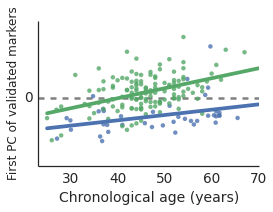

In [10]:
fig, ax = subplots(1,1, figsize=(4,3))
rr = -1*vH[0]
k = fx.pred_c.index
hiv = fx.duration != 'Control'
age = fx.age

sns.regplot(*match_series(age.ix[k], rr.ix[ti(hiv==0)]),
            ax=ax, label='HIV+', ci=None)
sns.regplot(*match_series(age.ix[k], rr.ix[ti(hiv>0)]),
            ax=ax, label='Control', ci=None)
ax.set_ylabel('First PC of validated markers', size=12)
ax.set_xlabel('Chronological age (years)', size=14)

ax.set_yticks([0])
ax.axhline(0, ls='--', lw=2.5, color='grey', zorder=-1)
ax.set_xbound(23,70)
ax.set_ybound(-.25,.28)
prettify_ax(ax)
fig.tight_layout()
fig.savefig(FIGDIR + 'PC1_validated.pdf')

Here I am doing a drop-1 test for an interaction term of __age X HIV__.  In the second act of this analysis we filter a few more patients with data that doesn't agree between aging models.  In general I think these are bad samples, and removing them does improve this result and make the lines more parallel than shown here.  I'm not using these filters here because it seemed a little ad-hoc to go back and apply them before we even looked at aging models and it is generally hard to report an iterative analysis in a journal paper.  
* _m1_ is a model with age and HIV fit independently 
* _m2_ is a model with age, HIV, and an interaction term 

In [11]:
import statsmodels.api as sm

In [19]:
y = vH[0]
intercept = pd.Series(1, index=y.index)

X = pd.concat([intercept, age, hiv], axis=1, keys=['Intercept', 'age', 'HIV'])
X = X.dropna().ix[y.index]
m1 = sm.OLS(y, X).fit()

X = pd.concat([intercept, age, hiv, hiv*age], axis=1, keys=['Intercept', 'age', 'HIV', 'int'])
X = X.dropna().ix[y.index]
m2 = sm.OLS(y, X).fit()

In [17]:
m1.pvalues

Intercept    8.78e-15
age          2.64e-09
HIV          2.25e-16
dtype: float64

In [16]:
m2.pvalues

Intercept    1.13e-05
age          4.83e-03
HIV          7.05e-01
int          1.19e-01
dtype: float64

The interaction term does not have a significant contribution to the model.

In [20]:
m2.compare_lr_test(m1)

(2.4912199645619921, 0.11448295270975471, 1.0)

Here I'm calculating the effect sise of HIV presence across the top principal components.  The idea is that an effect of 25 years means the the presence of HIV has an equivalent effect as 25 years of age on the molecular signal. 

In [18]:
cc = {}
for i,y in vH.iteritems():
    mod_all = sm.OLS(y, X)
    res_ref = mod_all.fit()
    cc[i] = res_ref.params['HIV'] / res_ref.params['age']
cc = pd.Series(cc)
cc.head()

0     8.34
1    67.84
2     1.08
3    38.76
4   -77.23
dtype: float64

#### Association with HIV of Age Associated Probes

In [21]:
t_hiv = ttest_df(hiv, df_norm)

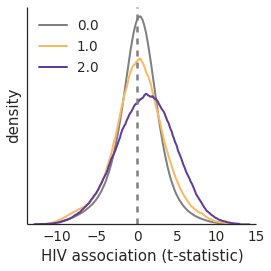

In [22]:
fig, ax = subplots(figsize=(4,4))
draw_dist(t_hiv, fx.rr, ax=ax, colors={0: 'grey', 1: colors_th[1], 2: colors_th[3]})
ax.set_xlabel('HIV association (t-statistic)')
ax.set_ylabel('density')
ax.axvline(0, ls='--', lw=2.5, color='grey')
ax.set_yticks([])
prettify_ax(ax)
fig.tight_layout()
fig.savefig(FIGDIR + 't_dens.pdf')

In [24]:
anova(fx.rr>1, t_hiv)

F    2586.27
p       0.00
dtype: float64

#### Association with HIV of Age Associated Probes- Split by Hypo/Hyper methylation

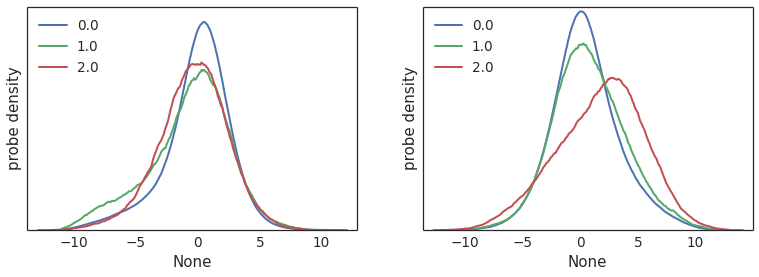

In [26]:
fig, axs = subplots(1,2, figsize=(13,4))
draw_dist(t_hiv.ix[ti(fx.mm > .5)], fx.rr, ax=axs[0])
draw_dist(t_hiv.ix[ti(fx.mm < .5)], fx.rr, ax=axs[1])

In [27]:
direction = fx.res.in_set_s1.multi_variate.age > 0

In [29]:
fisher_exact_test(fx.mm < .5, direction.ix[ti(fx.rr > 0)])

odds_ratio    6.03
p             0.00
dtype: float64

# Looking at Upstream Probes

These are probes that trend away from random, and validate in both cohorts. The idea of this analysis is to show that the shared effects of HIV and age are not soely due to a shared effect of general disordering of the methylome. 

In [30]:
r2 = ti(fx.rr > 1)
direction = fx.res.in_set_s1.multi_variate.age > 0
r3 = ti(((fx.mm < .5).ix[r2] == direction.ix[r2]) == False)
len(r3)

7967

In [31]:
idx = r3
U,S,vH = frame_svd(df_norm.ix[idx])

The first PC capture about 15% of the variation

In [34]:
p = S ** 2 / sum(S ** 2)
p[:5]

array([ 0.14613607,  0.09732037,  0.04516041,  0.03142676,  0.02604059])

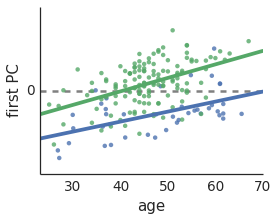

In [35]:
fig, ax = subplots(1,1, figsize=(4,3))
rr = vH[0]
hiv = fx.duration != 'Control'

sns.regplot(*match_series(age, rr.ix[ti(hiv==0)]),
            ax=ax, label='HIV+', ci=None)
sns.regplot(*match_series(age, rr.ix[ti(hiv>0)]),
            ax=ax, label='Control', ci=None)
ax.set_ylabel('first PC')
ax.set_yticks([0])
ax.axhline(0, ls='--', color='grey', zorder=-1)
ax.set_xbound(23,70)
ax.set_ybound(-.25,.25)
prettify_ax(ax)
fig.savefig(FIGDIR + 'PC1_validated.pdf')

Repeating the drop-1 model on this subset of the probes. 

In [36]:
y = vH[0]
intercept = pd.Series(1, index=y.index)

X = pd.concat([intercept, age, hiv], axis=1, 
              keys=['Intercept', 'age', 'HIV'])
X = X.dropna().ix[y.index]
m1 = sm.OLS(y, X).fit()

X = pd.concat([intercept, age, hiv, hiv*age], axis=1, 
              keys=['Intercept', 'age', 'HIV', 'int'])
X = X.dropna().ix[y.index]
m2 = sm.OLS(y, X).fit()

In [37]:
m2.pvalues

Intercept    5.41e-08
age          1.19e-04
HIV          3.11e-01
int          2.94e-01
dtype: float64

In [38]:
m1.pvalues

Intercept    4.79e-18
age          6.42e-12
HIV          3.07e-18
dtype: float64

In [39]:
m2.compare_lr_test(m1)

(1.1298061889274322, 0.28781668290682894, 1.0)